# LSTM Model for Stock Market Prediction

### Importing Libraries

In [1]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
np.random.seed(123)
import warnings
warnings.filterwarnings("ignore")


Using TensorFlow backend.
C:\Users\saura\Anaconda3\envs\AI2_course\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\saura\Anaconda3\envs\AI2_course\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\saura\Anaconda3\envs\AI2_course\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\saura\Anaconda3\envs\AI

### Reading Data 

In [2]:
df = pd.read_csv('ISEQ.csv')
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']
df.head()



,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
1997-07-10,1997-07-10,3484.330078,3501.919922,3483.060059,3490.590088,3490.590088,0.0
1997-07-11,1997-07-11,3490.590088,3518.879883,3490.590088,3514.439941,3514.439941,0.0
1997-07-14,1997-07-14,3514.439941,3538.080078,3514.020020,3535.129883,3535.129883,0.0
1997-07-15,1997-07-15,3535.129883,3544.030029,3515.840088,3527.060059,3527.060059,0.0
1997-07-16,1997-07-16,3527.060059,3582.679932,3523.439941,3576.949951,3576.949951,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6024 entries, 1997-07-10 to 2020-12-31
Data columns (total 7 columns):
Date         6024 non-null datetime64[ns]
Open         5925 non-null float64
High         5925 non-null float64
Low          5925 non-null float64
Close        5925 non-null float64
Adj Close    5925 non-null float64
Volume       5925 non-null float64
dtypes: datetime64[ns](1), float64(6)
memory usage: 376.5 KB


In [4]:
data=df.sort_index(ascending=True,axis=0)



### Data Cleaning Process 

In [5]:
data.fillna(df.mean(), inplace=True)

#### Creating New dataset with Date and Close columns

In [6]:
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

In [7]:
new_dataset.head()

,Date,Close
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


#### copying data from original dataset to new dataset 

In [8]:
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]


In [9]:
new_dataset.head()


,Date,Close
0,1997-07-10 00:00:00,3490.59
1,1997-07-11 00:00:00,3514.44
2,1997-07-14 00:00:00,3535.13
3,1997-07-15 00:00:00,3527.06
4,1997-07-16 00:00:00,3576.95


In [10]:
new_dataset.index=new_dataset.Date

In [11]:
new_dataset.drop("Date",axis=1,inplace=True)

In [12]:
new_dataset.head()

,Close
Date,
1997-07-10,3490.59
1997-07-11,3514.44
1997-07-14,3535.13
1997-07-15,3527.06
1997-07-16,3576.95


In [13]:
new_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6024 entries, 1997-07-10 to 2020-12-31
Data columns (total 1 columns):
Close    6024 non-null object
dtypes: object(1)
memory usage: 94.1+ KB


In [14]:
final_dataset=data

In [15]:
final_dataset.drop("Date",axis=1,inplace=True)
final_dataset.drop("Open",axis=1,inplace=True)
final_dataset.drop("High",axis=1,inplace=True)
final_dataset.drop("Low",axis=1,inplace=True)
final_dataset.drop("Adj Close",axis=1,inplace=True)
final_dataset.drop("Volume",axis=1,inplace=True)



In [16]:
final_dataset.head()

,Close
Date,
1997-07-10,3490.590088
1997-07-11,3514.439941
1997-07-14,3535.129883
1997-07-15,3527.060059
1997-07-16,3576.949951


### Spliting  the Data in Training and validation dataset

In [17]:
train_data=final_dataset[0:4217]
valid_data=final_dataset[4217:]


### Scaling the data as LSTM needs data to be scaled in 0's and 1's

In [18]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(new_dataset)


### Initializing two lists and appending data, taking 90 days data to predict the next day data 

In [19]:
x_train_data,y_train_data=[],[]
for i in range(90,len(train_data)):
    x_train_data.append(scaled_data[i-90:i,0])
    y_train_data.append(scaled_data[i,0])

### Converting trainning data into array and Reshaping the data

In [20]:
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))


### LSTM Model 

In [21]:
# Initializing LSTM Model
lstm_model=Sequential()

# Adding 1st LSTM layer
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))

# Adding 2nd LSTM layer
lstm_model.add(LSTM(units=50))

# Adding Dropout layer
lstm_model.add(Dropout(0.2))

# Output layer
lstm_model.add(Dense(1))

# Compiling the Neural Network
lstm_model.compile(loss='mean_squared_error',optimizer='adam')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
from keras.callbacks import (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)

EarlyStopping - Stop training when a monitored metric has stopped improving.
monitor - quantity to be monitored.

min_delta - minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.

patience - number of epochs with no improvement after which training will be stopped.

ReduceLROnPlateau - Reduce learning rate when a metric has stopped improving.
factor - factor by which the learning rate will be reduced. new_lr = lr * factor.

In [23]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h6', monitor='val_loss', verbose=1, 
                      save_best_only=True, save_weights_only=True)


Wall time: 0 ns


### Model Fitting

In [24]:

history = lstm_model.fit(x_train_data,y_train_data, shuffle=True, epochs=100, 
               callbacks=[es, rlr, mcp] , validation_split=0.2, batch_size=96, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 3301 samples, validate on 826 samples
Epoch 1/100
3301/3301 [==============================] - 8s 2ms/step - loss: 0.0336 - val_loss: 0.0077

Epoch 00001: val_loss improved from inf to 0.00765, saving model to weights.h6
Epoch 2/100
3301/3301 [==============================] - 6s 2ms/step - loss: 0.0038 - val_loss: 6.0188e-04

Epoch 00002: val_loss improved from 0.00765 to 0.00060, saving model to weights.h6
Epoch 3/100
3301/3301 [==============================] - 7s 2ms/step - loss: 0.0028 - val_loss: 4.7782e-04

Epoch 00003: val_loss improved from 0.00060 to 0.00048, saving model to weights.h6
Epoch 4/100
3301/3301 [==============================] - 7s 2ms/step - loss: 0.0023 - val_loss: 4.5589e-04

Epoch 00004: val_loss improved from 0.00048 to 0.00046, saving model to weights.h6
Epoch 5/100
3301/3301 [==============================] - 7s 2ms/step - loss: 0.0022 - val_loss: 4.7865e-04

Epoch 00005: val_loss did not improve fro

3301/3301 [==============================] - 9s 3ms/step - loss: 0.0016 - val_loss: 4.1424e-04

Epoch 00045: val_loss did not improve from 0.00041
Epoch 46/100
3301/3301 [==============================] - 7s 2ms/step - loss: 0.0016 - val_loss: 4.1884e-04

Epoch 00046: val_loss did not improve from 0.00041
Epoch 47/100
3301/3301 [==============================] - 7s 2ms/step - loss: 0.0016 - val_loss: 4.1309e-04

Epoch 00047: val_loss improved from 0.00041 to 0.00041, saving model to weights.h6
Epoch 48/100
3301/3301 [==============================] - 8s 2ms/step - loss: 0.0017 - val_loss: 4.1456e-04

Epoch 00048: val_loss did not improve from 0.00041
Epoch 49/100
3301/3301 [==============================] - 7s 2ms/step - loss: 0.0016 - val_loss: 4.1149e-04

Epoch 00049: val_loss improved from 0.00041 to 0.00041, saving model to weights.h6
Epoch 50/100
3301/3301 [==============================] - 7s 2ms/step - loss: 0.0017 - val_loss: 4.1526e-04

Epoch 00050: val_loss did not improve fr

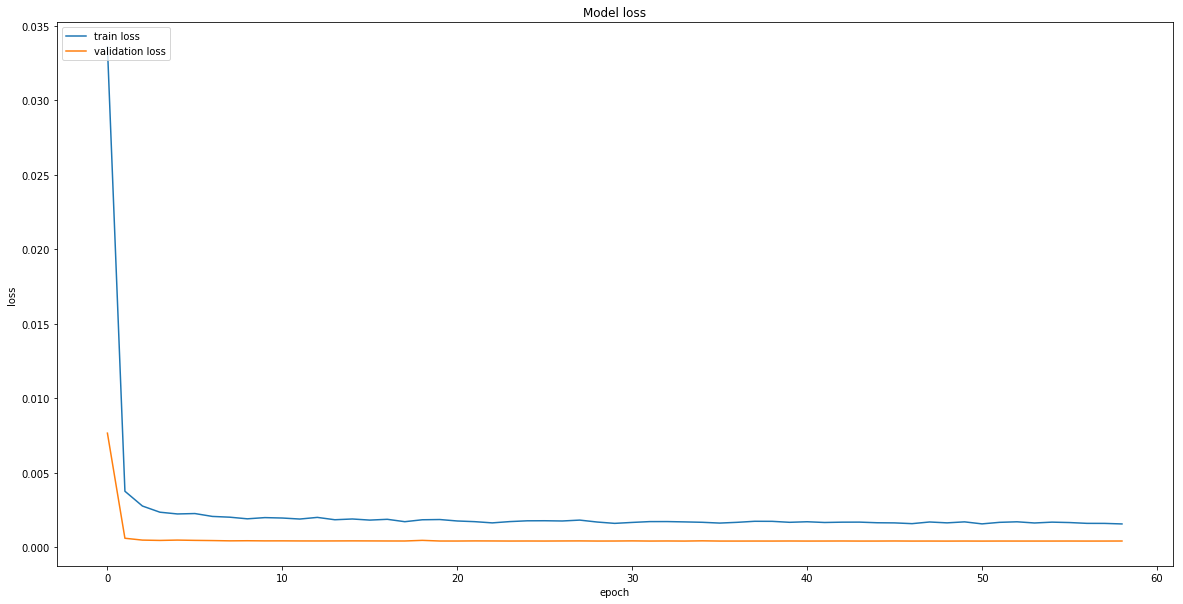

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [26]:
x_train_data.shape

(4127, 90, 1)

### Testing 

In [27]:
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-90:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)


In [28]:
X_test=[]
for i in range(90,inputs_data.shape[0]):
    X_test.append(inputs_data[i-90:i,0])

In [29]:
X_test = np.array(X_test)

In [30]:
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

### Prediction

In [31]:
predicted_closing_price=lstm_model.predict(X_test)

In [32]:
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

In [60]:
train_data=new_dataset[:4217]
valid_data=new_dataset[4217:]


In [61]:
valid_data['Predictions']=predicted_closing_price

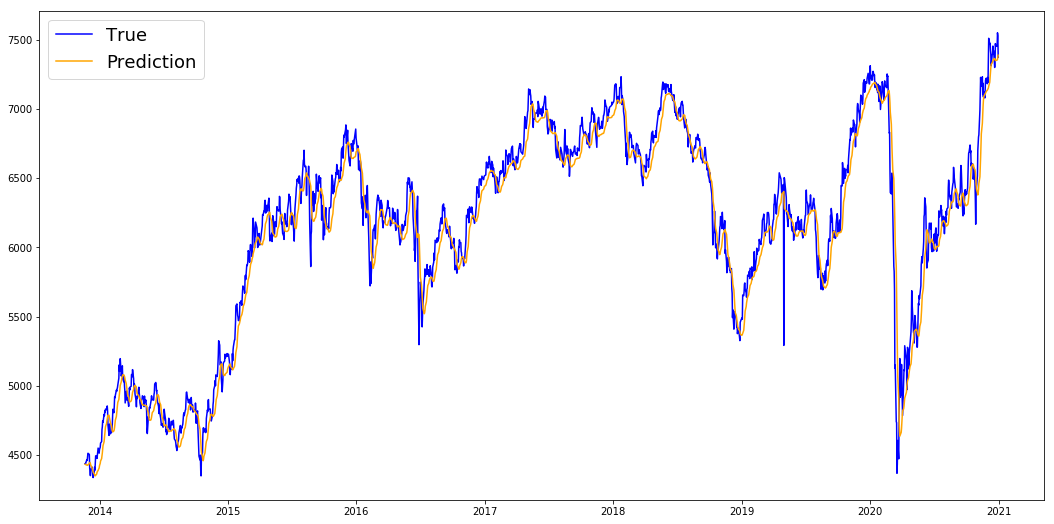

In [79]:
plt.figure(figsize = (18,9))
plt.plot(valid_data['Close'],color='b',label='True')
plt.plot(valid_data['Predictions'],color='orange',label='Prediction')
plt.legend(fontsize=18)
plt.show()


In [36]:
close=valid_data['Close']


In [37]:
pred=valid_data['Predictions']
error = (pred - close)**2
s=error/len(X_test)


In [38]:
from sklearn import metrics


### Model Performance Metrics

In [39]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    print(f'ACCURACY is : {(100 - (mean_absolute_percentage_error(y_true, y_pred)))}',end='\n\n')

In [40]:
timeseries_evaluation_metrics_func(close, pred)

Evaluation metric results:-
MSE is : 24189.841622014017
MAE is : 112.91823091804638
RMSE is : 155.53083817048636
MAPE is : 1.8815787099300283
R2 is : 0.9558734823854625

ACCURACY is : 98.11842129006997



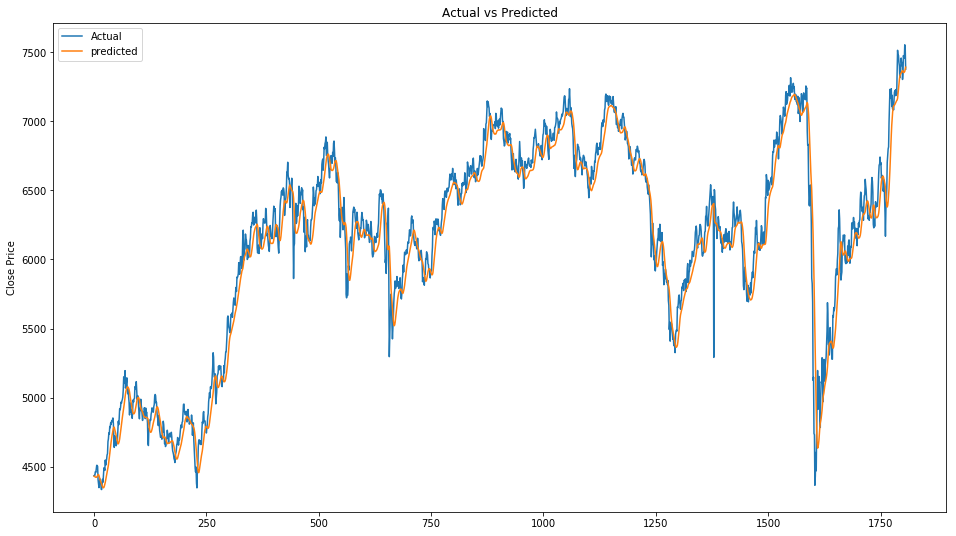

In [41]:
plt.plot( list(close))
plt.plot( list(pred))
plt.title("Actual vs Predicted")
plt.ylabel("Close Price")
plt.legend(('Actual','predicted'))
plt.show()